## Intro to Time Series Forecasting

Problem Definition
For this tutorial, we will build a model to predict the depth to groundwater of an aquifer located in Petrignano, Italy. The question we want to answer is

    What is the future depth to groundwater of a well belonging to the aquifier in Petrigrano over the next quarter?

    The wells field of the alluvial plain between Ospedalicchio di Bastia Umbra and Petrignano is fed by three underground aquifers separated by low permeability septa. The aquifer can be considered a water table groundwater and is also fed by the Chiascio river. The groundwater levels are influenced by the following parameters: rainfall, depth to groundwater, temperatures and drainage volumes, level of the Chiascio river.

    Indeed, both rainfall and temperature affect features like level, flow, depth to groundwater and hydrometry some time after it fell down.

In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # supress warnings

df = pd.read_csv('Aquifer_Petrignano.csv')

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis = 1)

# simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3







Since we are working with time series, the most essential features are the time related feature. In this example, we have the column 'Date' which uniquely identifies a day. Ideally, the data is already in chronological order and the time stamps are equidistant in time series. This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

This column is provided in string format. Let's convert it to the 'datetime64[ns]' data type.

In [34]:
from datetime import datetime, date

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000







### Features:

Rainfall indicates the quantity of rain falling (mm)
Temperature indicates the temperature (°C)
Volume indicates the volume of water taken from the drinking water treatment plant (m 3
 )
Hydrometry indicates the groundwater level (m)
Target:

Depth to Groundwater indicates the groundwater level (m from the ground floor)

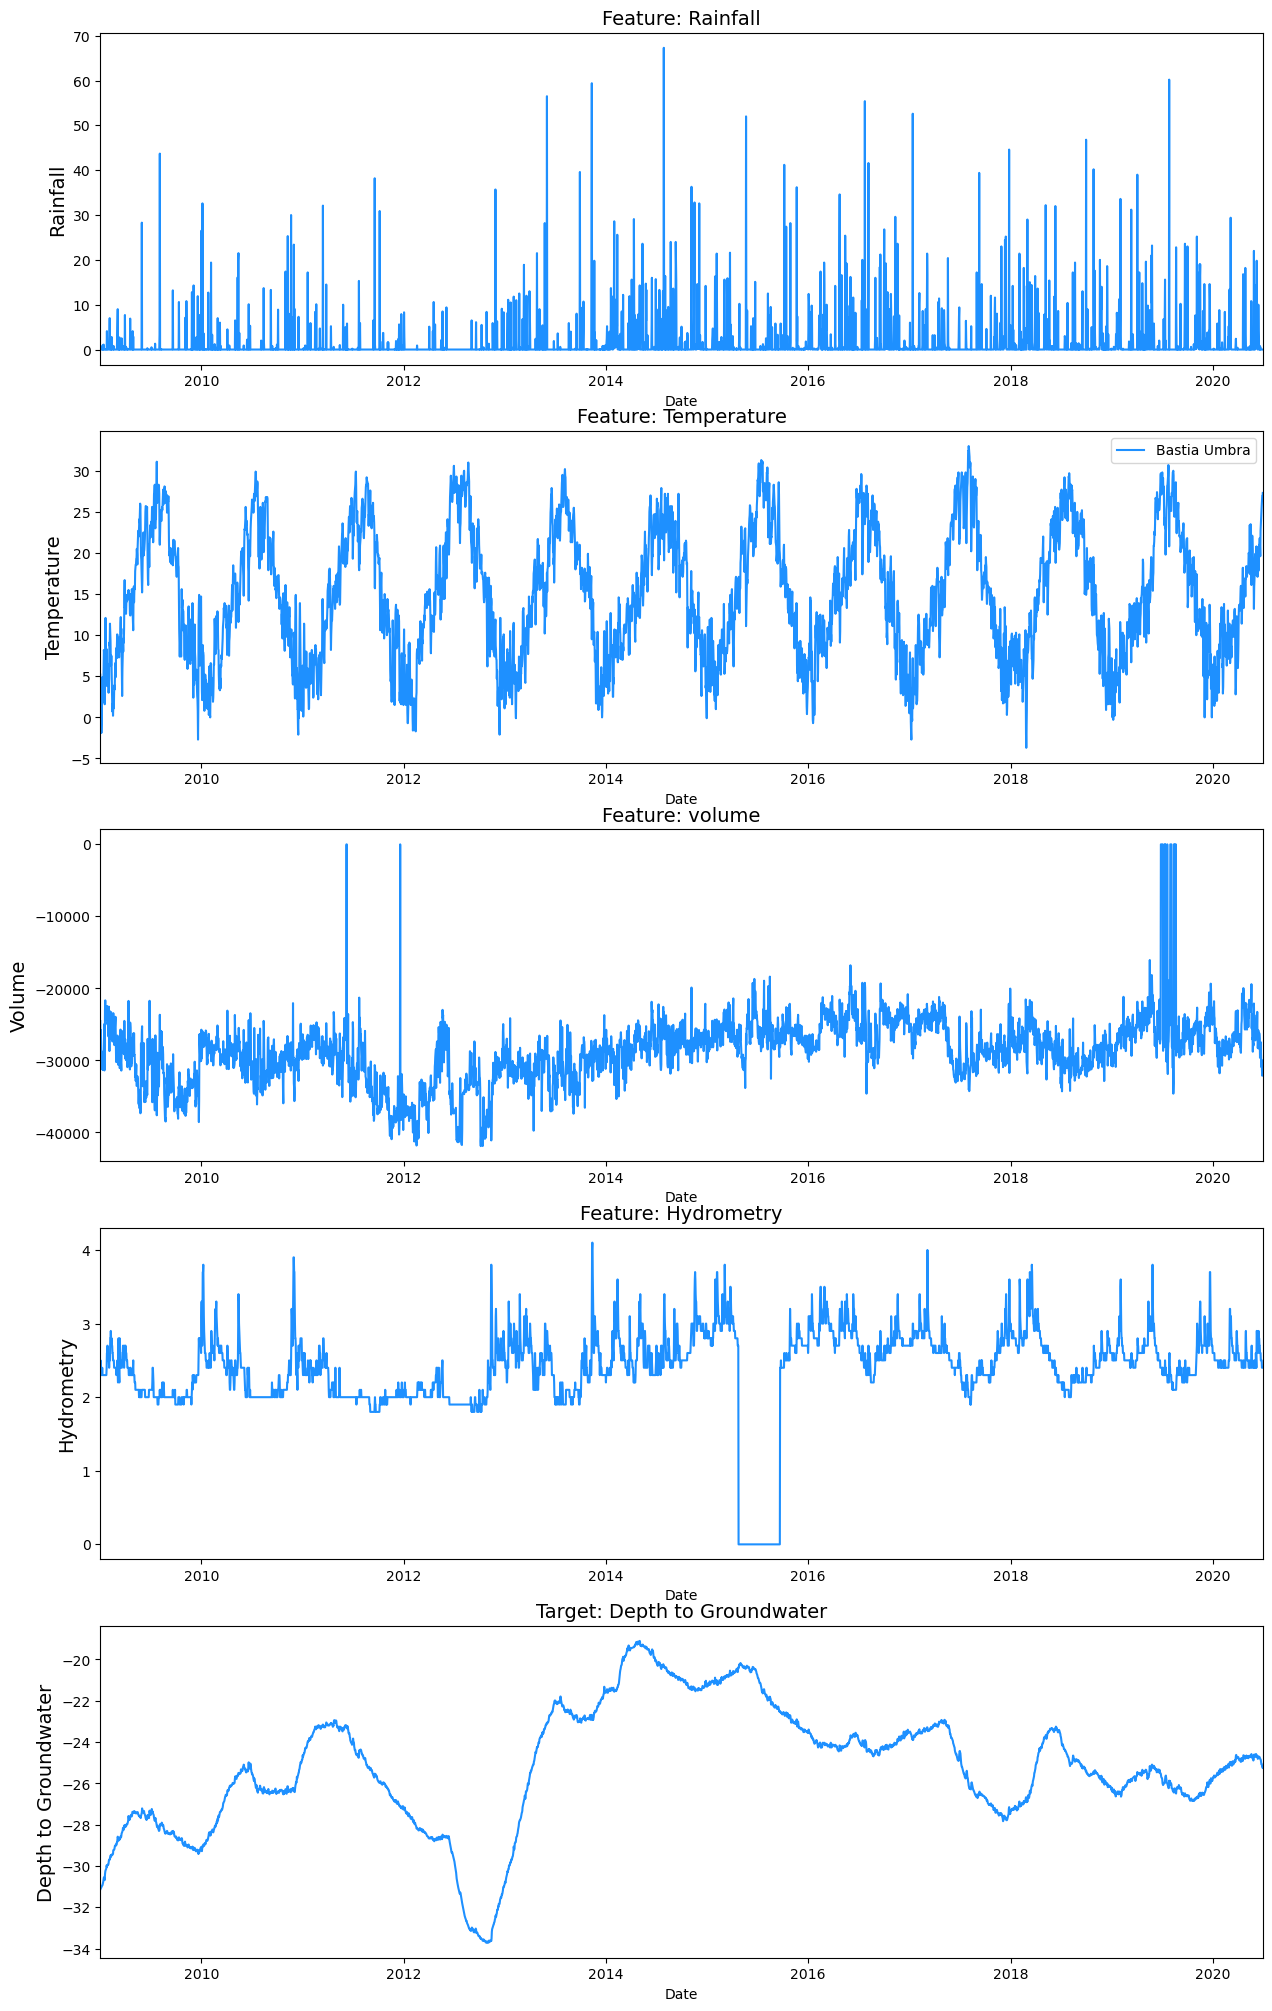

In [35]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue', label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.show()

### Data Preprocessing

Chronological Order and Equidistant Timestamps
The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data (see Resampling).

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

In [36]:
# sort values by timestamp (not necessary in this case)
df = df.sort_values(by='Date')

# check time intervals
df['Time_Interval'] = df.Date - df.Date.shift(1)

df[['Date', 'Time_Interval']].head()

,Date,Time_Interval
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [37]:
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

Time_Interval
1 days    4198
Name: count, dtype: int64


### Handling Missing Values
We can see that Depth_to_Groundwater has missing values.

Furthermore, plotting the time series reveals that there seem to be some implausible zero values for Drainage_Volume, and River_Hydrometry. We will have to clean them by replacing them by nan values and filling them afterwards.

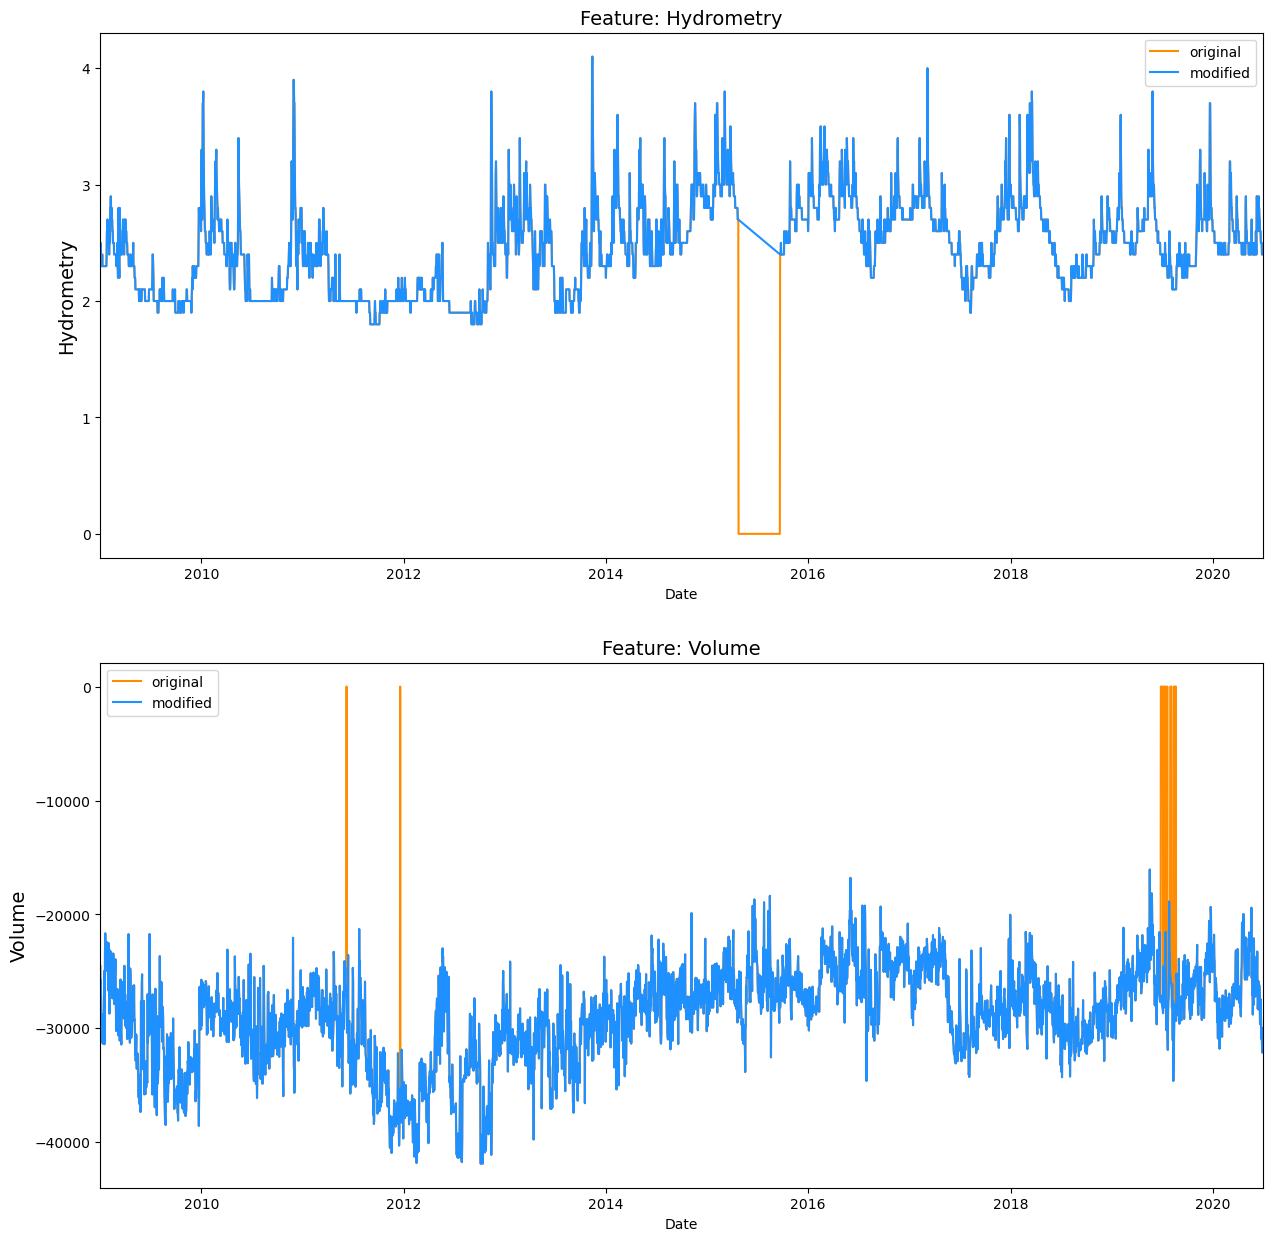

In [38]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0),np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'modified')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

Now we have to think about what to do with these missing values.

/var/folders/kq/n9fv8tys74s58y31hg96y6f80000gn/T/ipykernel_3664/1905464197.py:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


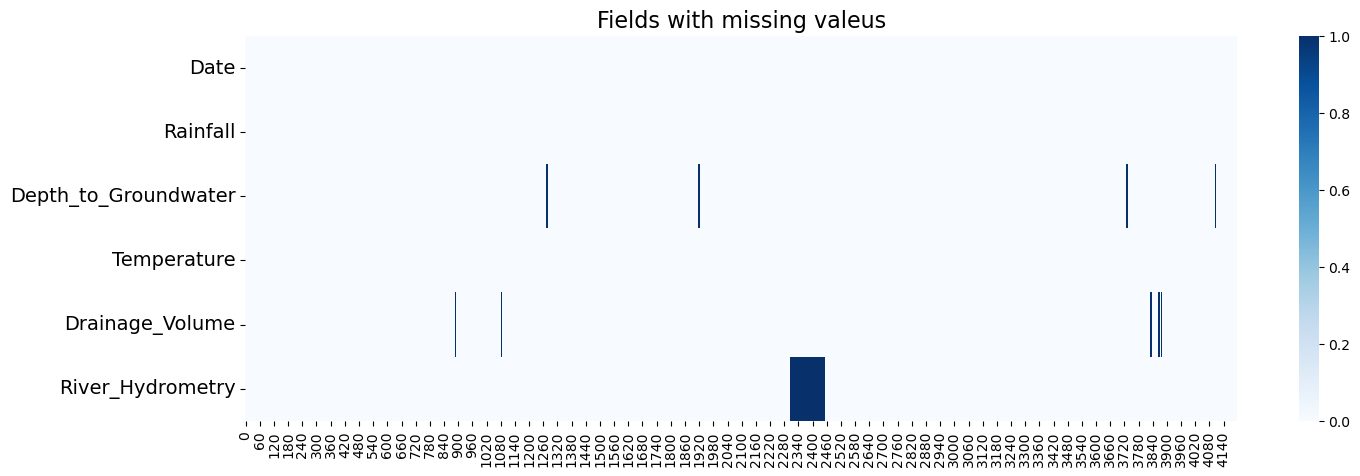

In [39]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with missing valeus', fontsize=16)
# for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

Option 1: Fill NaN with Outlier or Zero

In this specific example filling the missing value with an outlier value such as -999 is not a good idea. However, many notebooks in this challenge have been using -999.

Option 2: Fill NaN with Mean Value

Also in this example, we can see that filling NaNs with the mean value is also not sufficient.

Option 3: Fill NaN with Last Value with .ffill()

Filling NaNs with the last value is already a little bit better in this case.

Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()

Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring values.

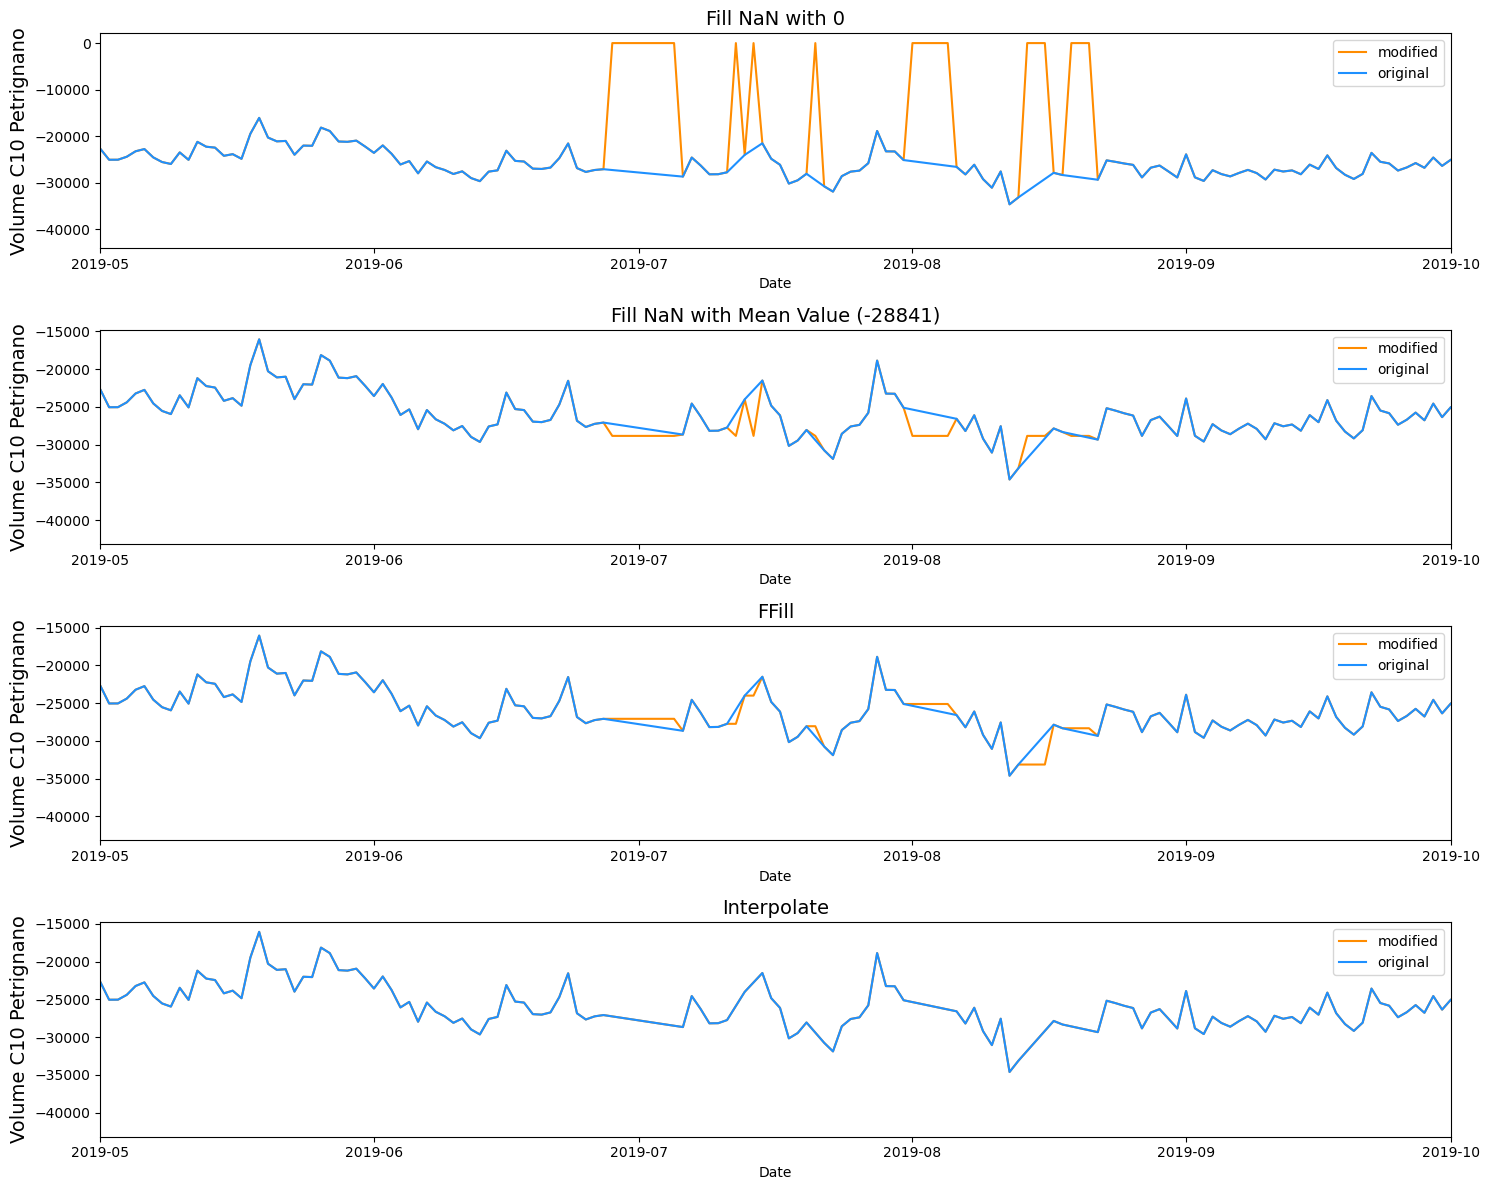

In [46]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

In [47]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

### Resampling¶
Resampling can provide additional information on the data. There are two types of resampling:

Upsampling is when the frequency of samples is increased (e.g. days to hours)
Downsampling is when the frequency of samples is decreased (e.g. days to weeks)
In this example, we will do some downsampling with the .resample() function.

TypeError: lineplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

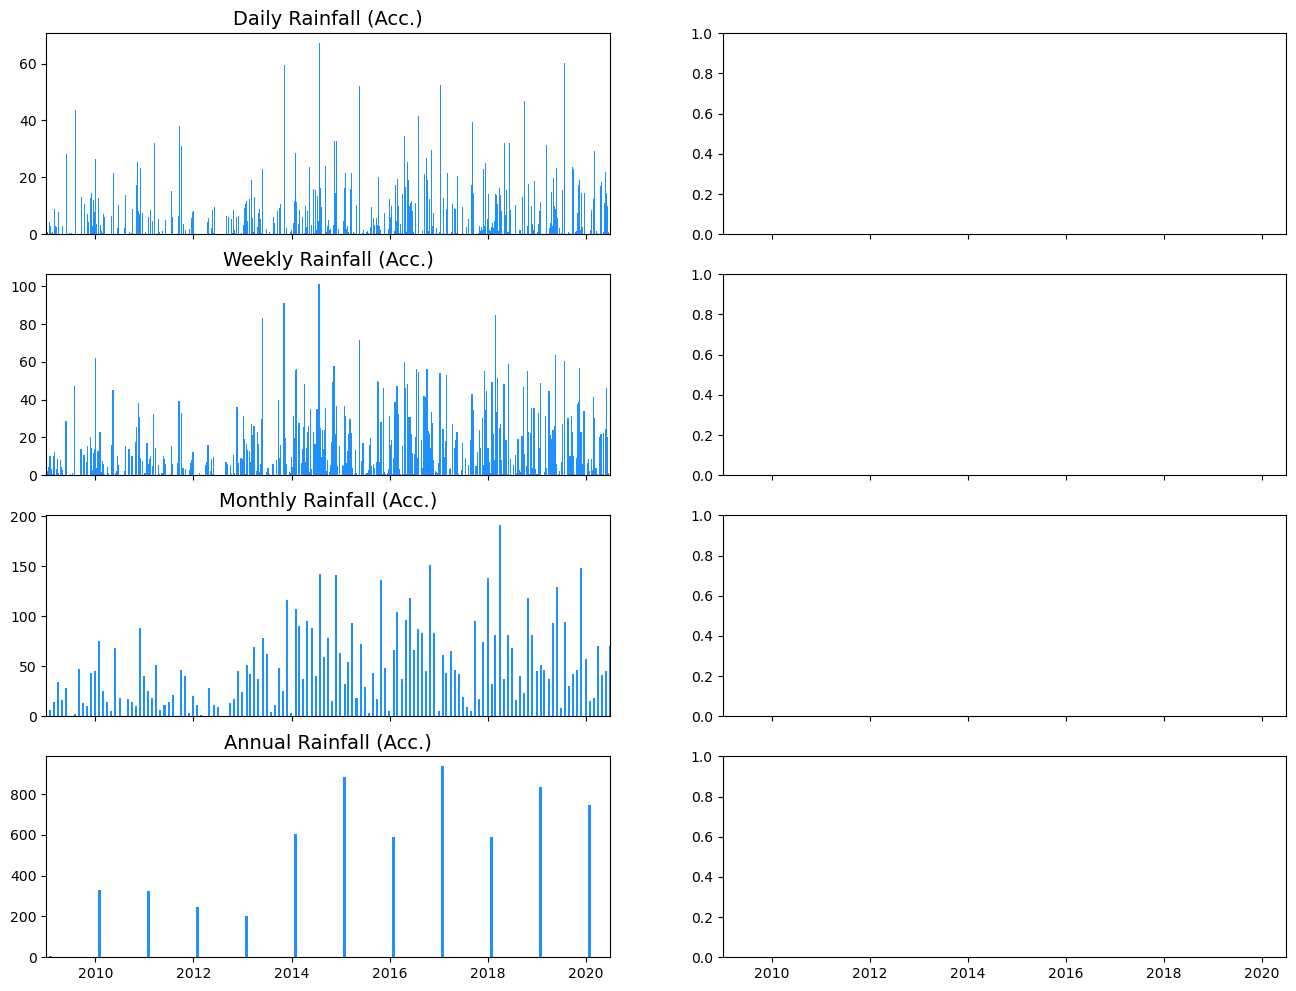

In [48]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))

ax[0, 0].bar(df.Date, df.Rainfall, width=5, color='dodgerblue')
ax[0, 0].set_title('Daily Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)
ax[1, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=10, color='dodgerblue')
ax[1, 0].set_title('Weekly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('M', on='Date').sum().reset_index(drop=False)
ax[2, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=15, color='dodgerblue')
ax[2, 0].set_title('Monthly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('12M', on='Date').sum().reset_index(drop=False)
ax[3, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=20, color='dodgerblue')
ax[3, 0].set_title('Annual Rainfall (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df.Date, df.Temperature, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('365D', on='Date').mean().reset_index(drop=False)
sns.lineplot(resampled_df.Date, resampled_df.Temperature, color='dodgerblue', ax=ax[3, 1])
ax[3, 1].set_title('Annual Temperature (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_ylim([-5, 35])
plt.show()

In this example, resampling would not be necessary. On the other hand, there is no necessity to look at the daily data. Considering weekly data seems to be sufficient as well. Therefore, we will downsample the data to a weekly basis.

In [49]:
df_downsampled = df[['Date',
                     'Depth_to_Groundwater', 
                     'Temperature',
                     'Drainage_Volume', 
                     'River_Hydrometry'
                    ]].resample('7D', on='Date').mean().reset_index(drop=False)

df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall'
                                ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df = df_downsampled

### Stationarity
Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

constant mean and mean is not time-dependent
constant variance and variance is not time-dependent
constant covariance and covariance is not time-dependent
If a time series has a specific (stationary) behavior over a given time interval, then it can be assumed that the time series will behave the same at a later time.

Time series with trend and/or seasonality are not stationary. Trend indicates that the mean is not constant over time and seasonality indicates that the variance is not constant over time.

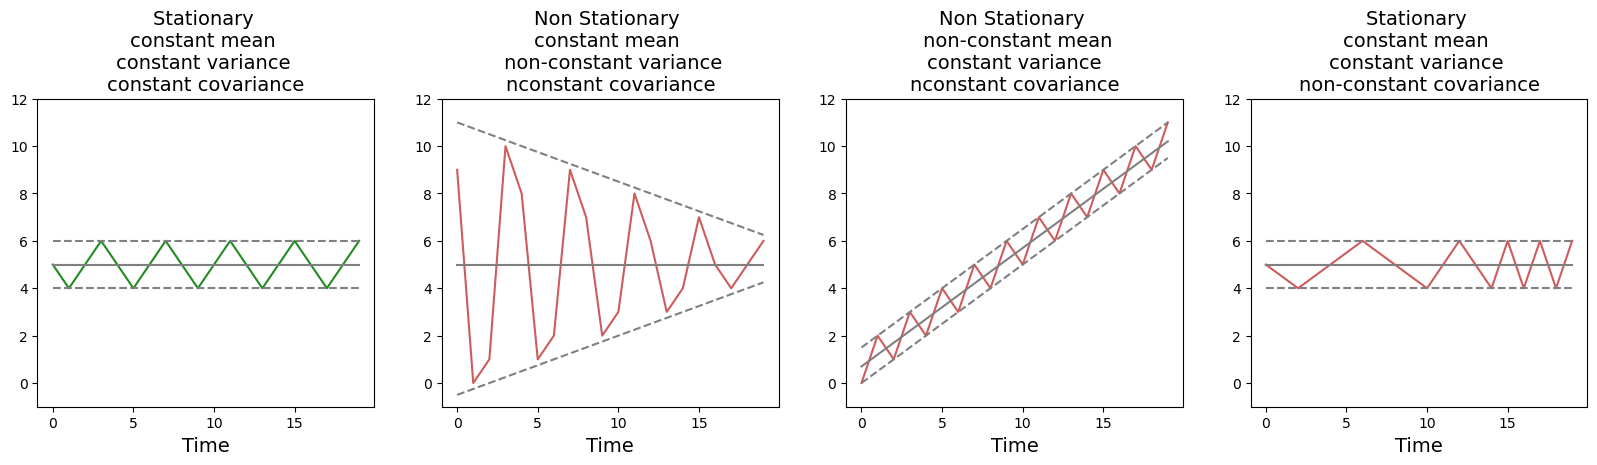

In [50]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)

The check for stationarity can be done via three different approaches:

1. visually: plot time series and check for trends or seasonality
2. basic statistics: split time series and compare the mean and variance of each partition
3. statistical test: Augmented Dickey Fuller test
Let's do the visual check first. We can see that all features except Temperature have non-constant mean and non-constant variance. Therefore, none of these seem to be stationary. However, Temperature shows strong seasonality (hot in summer, cold in winter) and therefore it is not stationary either.

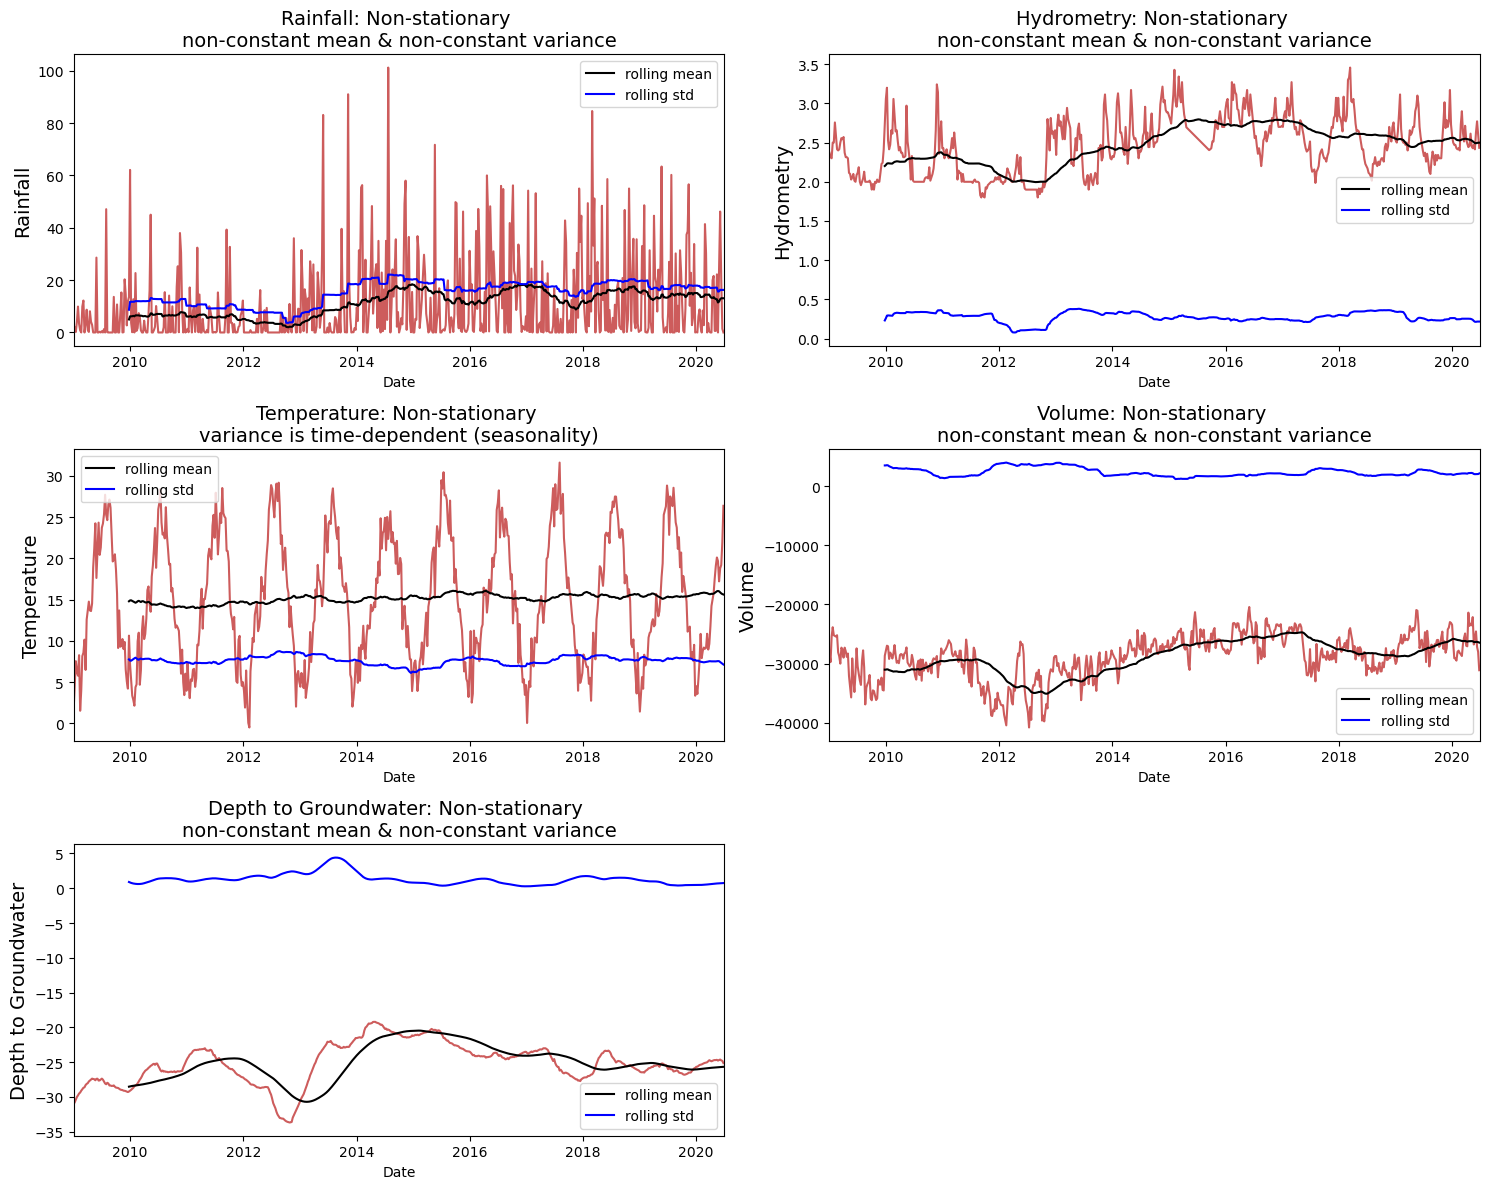

In [51]:
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Rainfall, ax=ax[0, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature, ax=ax[1, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry, ax=ax[0, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume, ax=ax[1, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater, ax=ax[2, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).mean(), ax=ax[2, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).std(), ax=ax[2, 0], color='blue', label='rolling std')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(3):
    ax[i,0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i,1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Next, we will check the underlying statistics. For this we will split the time series into two sections and check the mean and the variance. You could do more partitions if you wanted.

With this method, Temperature and River_Hydrometry show somewhat similar (constant) mean and variance and could be seen as stationary. However, with this method, we are not able to see the seasonality in the Temperature feature.

In [52]:
num_partitions = 2
partition_length = int(len(df) / num_partitions)

partition1_mean = df.head(partition_length).mean()
partition1_var = df.head(partition_length).var()
partition2_mean = df.tail(partition_length).mean()
partition2_var = df.tail(partition_length).var()

TypeError: 'DatetimeArray' with dtype datetime64[ns] does not support reduction 'var'

Let's evaluate the histograms. Since we are looking at the mean and variance, we are expecting that the data conforms to a Gaussian distribution (bell shaped distribution) in case of stationarity.

/var/folders/kq/n9fv8tys74s58y31hg96y6f80000gn/T/ipykernel_3664/1733523395.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.Rainfall.fillna(np.inf), ax=ax[0, 0], color='indianred')
/var/folders/kq/n9fv8tys74s58y31hg96y6f80000gn/T/ipykernel_3664/1733523395.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe575

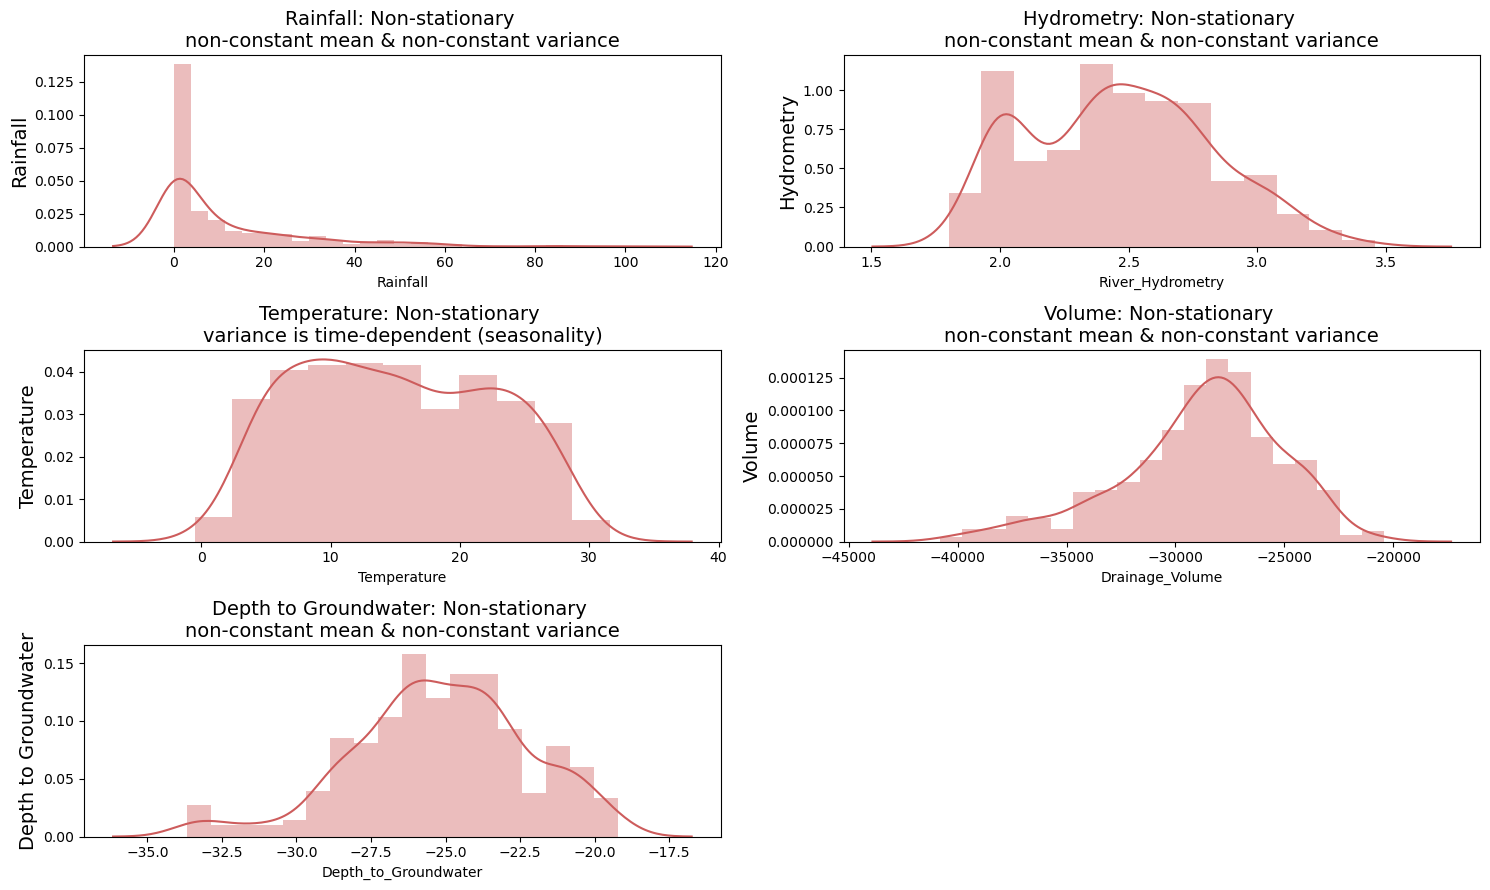

In [53]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df.Rainfall.fillna(np.inf), ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.distplot(df.Temperature.fillna(np.inf), ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.distplot(df.River_Hydrometry.fillna(np.inf), ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.distplot(df.Drainage_Volume.fillna(np.inf), ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.distplot(df.Depth_to_Groundwater.fillna(np.inf), ax=ax[2, 0], color='indianred')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

- Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).
- Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

- **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

- **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [55]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Depth_to_Groundwater.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']